<a id="top7"></a>
# Dense networks

This notebook presents a few Dense Networks models with and without hidden layers:

- [Data preparation](#part7a)
- [Dense network without hidden layers](#part7b)
- [Dense network with two hidden layers](#part7c)

### <a id='part7a'>Data preparation</a>

Let's import the dataset previously exported and extract `X` feature matrix and `y` numerical target:

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # to avoid TensorFlow compiler flag message

# Importing tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import activations
from tensorflow.keras import initializers

# Import the dataset and verify that the upload is successful
df = pd.read_csv('emotions_data_transformed.csv')

# Convert target to numerical values
df['emotion'].replace({'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}, inplace=True)
df['gender'].replace({'female':0,'male':1}, inplace=True)

# Create feature matrix (X) and numerical target (y)
X = df.drop(columns=['path','filename','dataset','duration','age','emotion'])
y = df.emotion.values

Let's split the data:

In [2]:
from sklearn.model_selection import train_test_split

# Create train and test set
X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.9, shuffle=True, stratify=y, random_state=0)

# Checking size
print('Shape of X_tr: ', X_tr.shape)
print('Shape of y_tr: ', y_tr.shape)
print('Shape of X_te: ', X_te.shape)
print('Shape of y_te: ', y_te.shape)

Shape of X_tr:  (8361, 90)
Shape of y_tr:  (8361,)
Shape of X_te:  (930, 90)
Shape of y_te:  (930,)


Let's rescale the data:

In [3]:
# Scale the data
from sklearn.preprocessing import StandardScaler

# Create Standard scaler
scaler = StandardScaler()

# Rescale data
X_tr_rescaled = scaler.fit_transform(X_tr)
X_te_rescaled = scaler.transform(X_te)

### <a id='part7b'>Model without hidden layers</a>

In [4]:
# Create fully connected model without hidden layers
model = Sequential()

# Output layer with 7 units as for the 7 categories
model.add(Dense(units=7, activation=activations.softmax, input_dim=90, kernel_initializer=initializers.VarianceScaling(scale=1.0, seed=0)))

# Network summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 637       
                                                                 
Total params: 637
Trainable params: 637
Non-trainable params: 0
_________________________________________________________________


Before fitting the model I will provide the `class_weights` due to the imbalanced classed, and an `EarlyStopping` callback function.

In [5]:
from sklearn.utils.class_weight import compute_class_weight

# Computing weights and formatting the output as dictionary
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_tr), y= y_tr)
class_weights = dict(zip(np.unique(y_tr), class_weights))

# Creates 'EarlyStopping' callback
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Define loss function, optimizer and metrics to track during training
model.compile(optimizer="sgd", loss="sparse_categorical_crossentropy", metrics=["acc"])

# Fit model
history = model.fit(
    x=X_tr_rescaled,
    y=y_tr,
    validation_split=0.3,             # Split training/validation sets by 70/30 ratio at each epoch
    class_weight=class_weights,       # Apply class weights
    callbacks=[earlystopping_cb],     # Apply earlystopping callback
    batch_size=32,                    # 32 samples for each batch
    epochs=100,                       # Running 100 epochs
    shuffle=True,                     # Shuffle training data at each epoch
)

Epoch 1/100
183/183 [==============================] - 1s 2ms/step - loss: 1.5024 - acc: 0.4356 - val_loss: 1.2234 - val_acc: 0.5779
Epoch 2/100
183/183 [==============================] - 0s 1ms/step - loss: 1.0703 - acc: 0.6326 - val_loss: 1.0134 - val_acc: 0.6517
Epoch 3/100
183/183 [==============================] - 0s 1ms/step - loss: 0.9379 - acc: 0.6798 - val_loss: 0.9045 - val_acc: 0.7019
Epoch 4/100
183/183 [==============================] - 0s 1ms/step - loss: 0.8622 - acc: 0.7138 - val_loss: 0.8499 - val_acc: 0.7242
Epoch 5/100
183/183 [==============================] - 0s 1ms/step - loss: 0.8111 - acc: 0.7314 - val_loss: 0.8012 - val_acc: 0.7401
Epoch 6/100
183/183 [==============================] - 0s 1ms/step - loss: 0.7739 - acc: 0.7432 - val_loss: 0.7740 - val_acc: 0.7517
Epoch 7/100
183/183 [==============================] - 0s 1ms/step - loss: 0.7459 - acc: 0.7532 - val_loss: 0.7445 - val_acc: 0.7605
Epoch 8/100
183/183 [==============================] - 0s 1ms/step - 

So, the first thing to notice is that the `EarlyStopping` function was not triggered even with 100 epochs, which means that the model was still improving a bit. 

Let's see what the training/validation curves can show about this process:

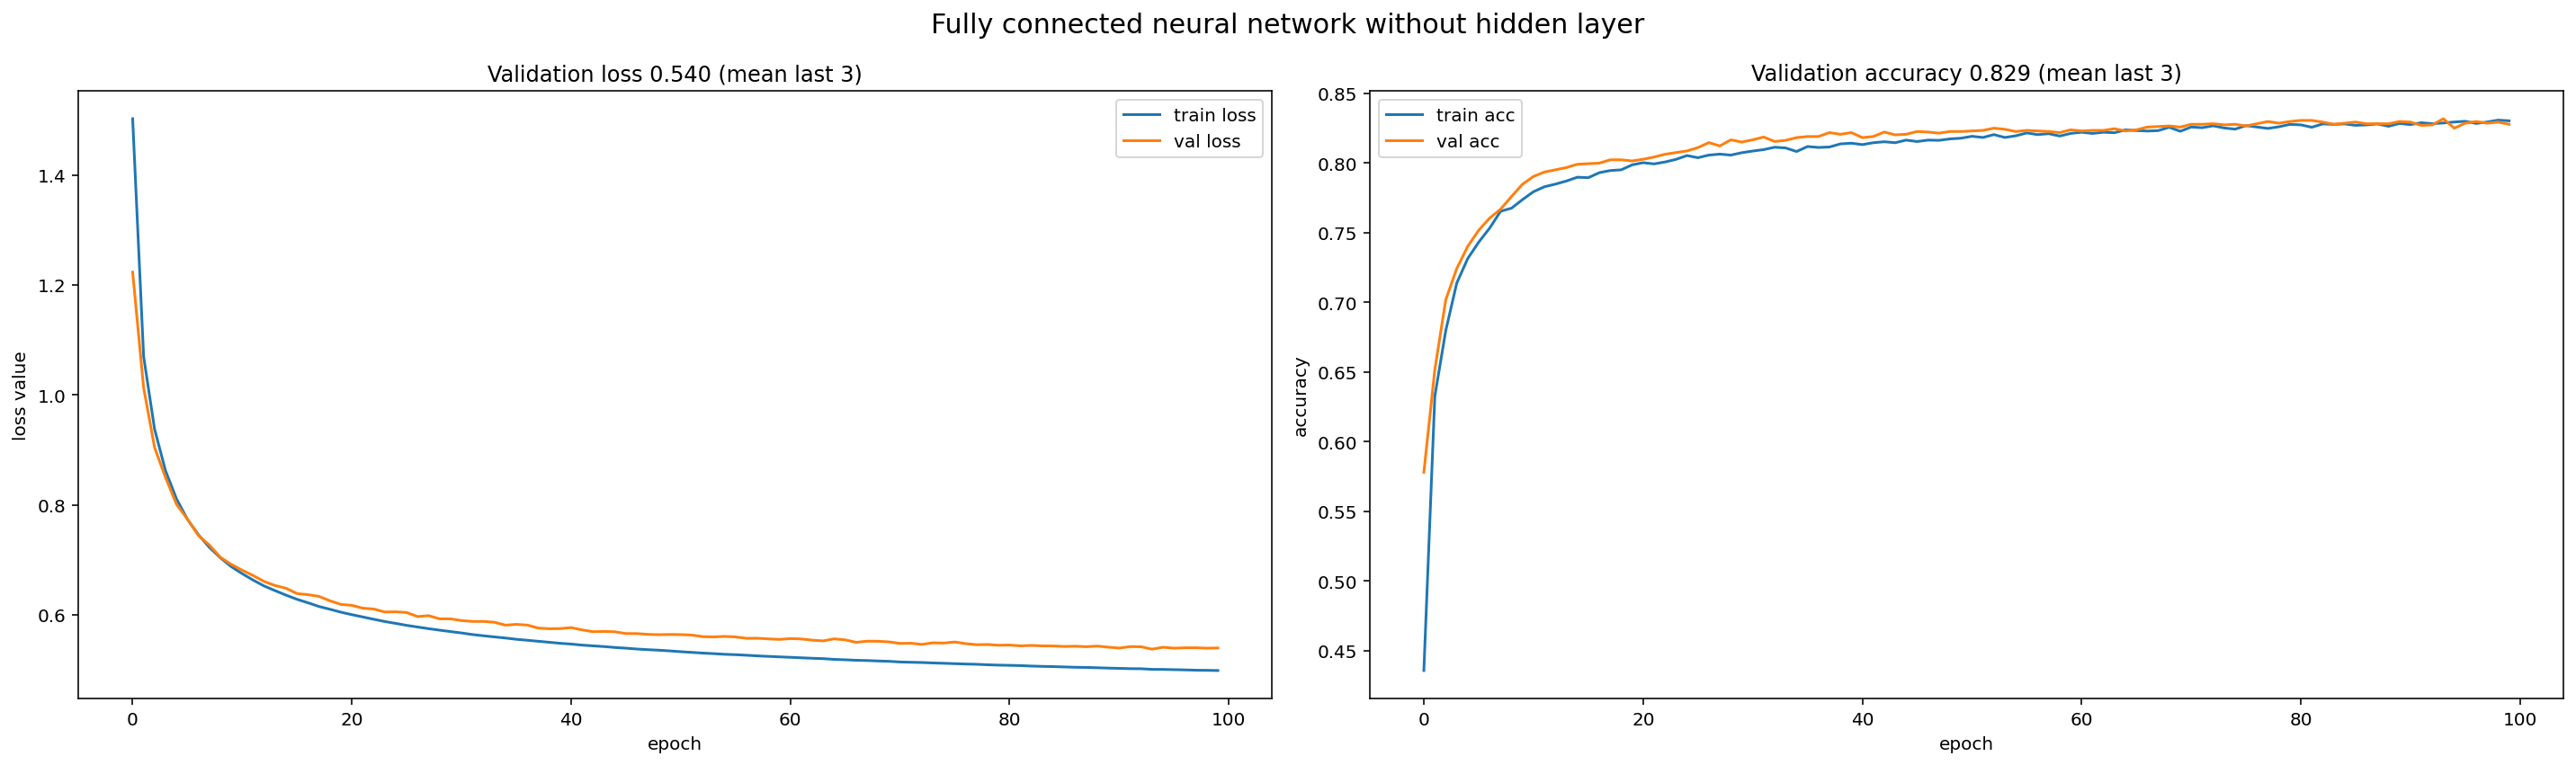

In [6]:
# Import libraries
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import numpy as np

# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

plt.suptitle('Fully connected neural network without hidden layer', size=15)

# Plot loss values
ax1.plot(history.history["loss"], label="train loss")
ax1.plot(history.history["val_loss"], label="val loss")
ax1.set_title(
    "Validation loss {:.3f} (mean last 3)".format(
        np.mean(history.history["val_loss"][-3:])  # last three values
    )
)
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss value")
ax1.legend()

# Plot accuracy values
ax2.plot(history.history["acc"], label="train acc")
ax2.plot(history.history["val_acc"], label="val acc")
ax2.set_title(
    "Validation accuracy {:.3f} (mean last 3)".format(
        np.mean(history.history["val_acc"][-3:])  # last three values
    )
)
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.legend()
plt.tight_layout()
plt.show()

The validation loss reaches a plateau after about 30 epochs, and its accuracy even slighlty earlier before the model begins to overfit.

Let's now evaluate the test scores using the `evaluate()` function on the test dataset:

In [7]:
(test_loss, test_accuracy) = model.evaluate(X_te_rescaled, y_te, batch_size=32)

print("Test loss: {:.2f}".format(test_loss))
print("Test accuracy: {:.2f}%".format(100 * test_accuracy))

30/30 [==============================] - 0s 4ms/step - loss: 0.5186 - acc: 0.8247
Test loss: 0.52
Test accuracy: 82.47%


30/30 [==============================] - 0s 722us/step


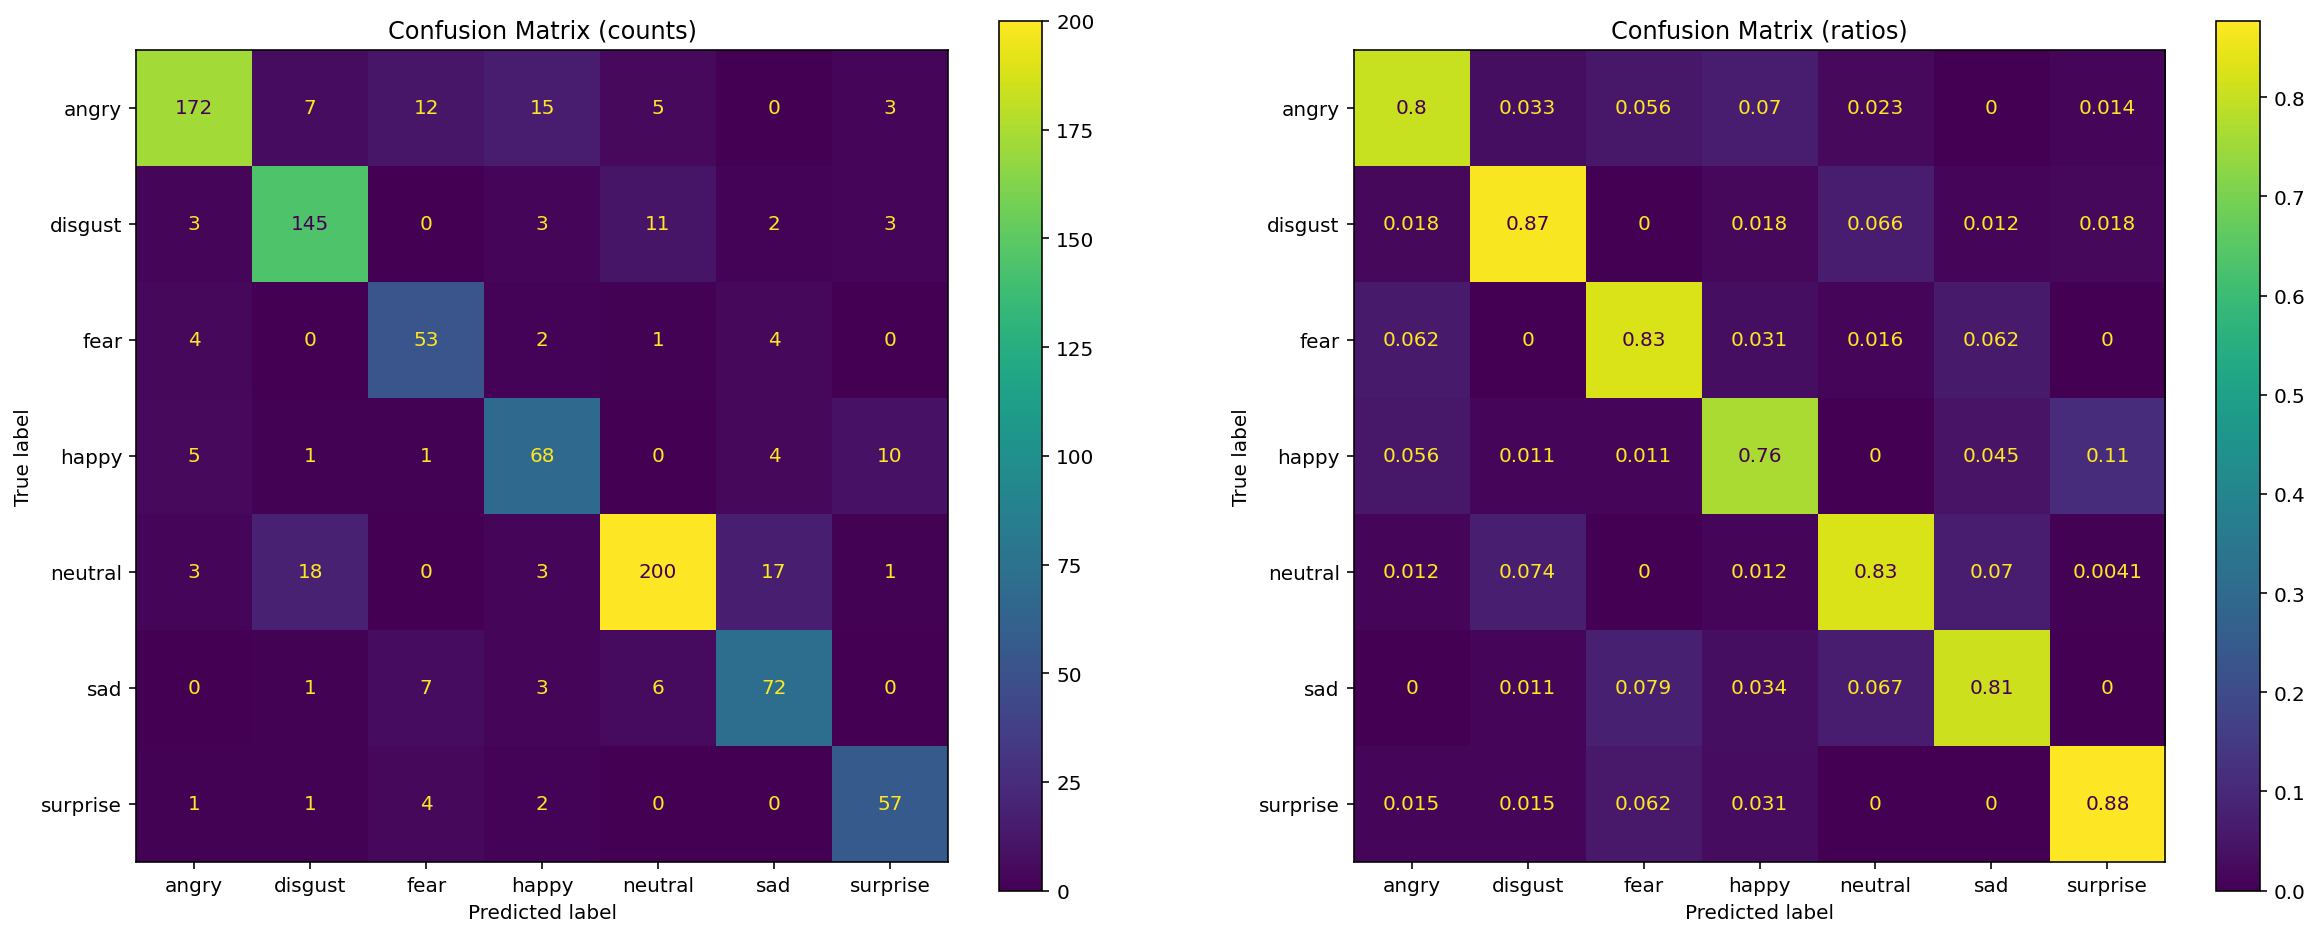

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay

# Compute test set predictions
predictions = model.predict(X_te_rescaled)

pred = []

for i in predictions:
    pred.append(np.argmax(i))
    
labels = {'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}

def plot_confusion_matrices(y_true, y_pred):

    # Create two subplots
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plots the standard confusion matrix
    ax1.set_title("Confusion Matrix (counts)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, ax=ax1)

    # Plots the normalized confusion matrix
    ax2.set_title("Confusion Matrix (ratios)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, normalize="true", ax=ax2)

    plt.show()

# Plot confusion matrices
plot_confusion_matrices(y_te, pred)

- The best prediction occurred for the `surprise` and `disgust` emotion
- The worst for the `happy` and `angry` categories

### <a id='part7c'>Model with hidden layers</a>

Now let's create a 3-layer dense network, therefore with two hidden layers.

I chose to use 256 units for one layer, and 64 for the other. Also I add L2 regularization with the `kernel_regularizer` parameter to each layer, in a way to reduce the overfitting of the model:

In [9]:
# Create model with hidden layers
model_hl = Sequential()

# Hidden layer 1
model_hl.add(Dense(units=256, 
                activation=activations.relu,
                input_dim=90,
                kernel_initializer=initializers.VarianceScaling(scale=1.0, seed=0),
                kernel_regularizer=tf.keras.regularizers.l2(0.001)))

# Hidden layer 2
model_hl.add(Dense(units=64,
                activation=activations.relu,
                kernel_initializer=initializers.VarianceScaling(scale=1.0, seed=0),
                kernel_regularizer=tf.keras.regularizers.l2(0.001)))

# Output layer
model_hl.add(Dense(units=7,
                activation=activations.softmax,
                kernel_initializer=initializers.VarianceScaling(scale=1.0, seed=0),
                kernel_regularizer=tf.keras.regularizers.l2(0.001)))

# Network summary
model_hl.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 256)               23296     
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 7)                 455       
                                                                 
Total params: 40,199
Trainable params: 40,199
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Define loss function, optimizer and metrics to track during training
model_hl.compile(optimizer="sgd", loss="sparse_categorical_crossentropy", metrics=["acc"])

# Fit model
history = model_hl.fit(
    x=X_tr_rescaled,
    y=y_tr,
    validation_split=0.3,             # Split training/validation sets by 70/30 ratio at each epoch
    class_weight=class_weights,       # Apply class weights
    callbacks=[earlystopping_cb],     # Apply earlystopping callback
    batch_size=32,                    # 32 samples for each batch
    epochs=100,                       # Running 100 epochs
    shuffle=True,                     # Shuffle training data at each epoch
)

Epoch 1/100
183/183 [==============================] - 1s 2ms/step - loss: 1.8127 - acc: 0.4658 - val_loss: 1.5108 - val_acc: 0.6190
Epoch 2/100
183/183 [==============================] - 0s 2ms/step - loss: 1.3258 - acc: 0.6668 - val_loss: 1.2189 - val_acc: 0.6995
Epoch 3/100
183/183 [==============================] - 0s 2ms/step - loss: 1.1343 - acc: 0.7271 - val_loss: 1.0605 - val_acc: 0.7529
Epoch 4/100
183/183 [==============================] - 0s 2ms/step - loss: 1.0233 - acc: 0.7673 - val_loss: 0.9911 - val_acc: 0.7780
Epoch 5/100
183/183 [==============================] - 0s 2ms/step - loss: 0.9495 - acc: 0.7922 - val_loss: 0.9327 - val_acc: 0.7983
Epoch 6/100
183/183 [==============================] - 0s 2ms/step - loss: 0.8937 - acc: 0.8098 - val_loss: 0.8799 - val_acc: 0.8171
Epoch 7/100
183/183 [==============================] - 0s 2ms/step - loss: 0.8512 - acc: 0.8209 - val_loss: 0.8671 - val_acc: 0.8218
Epoch 8/100
183/183 [==============================] - 0s 2ms/step - 

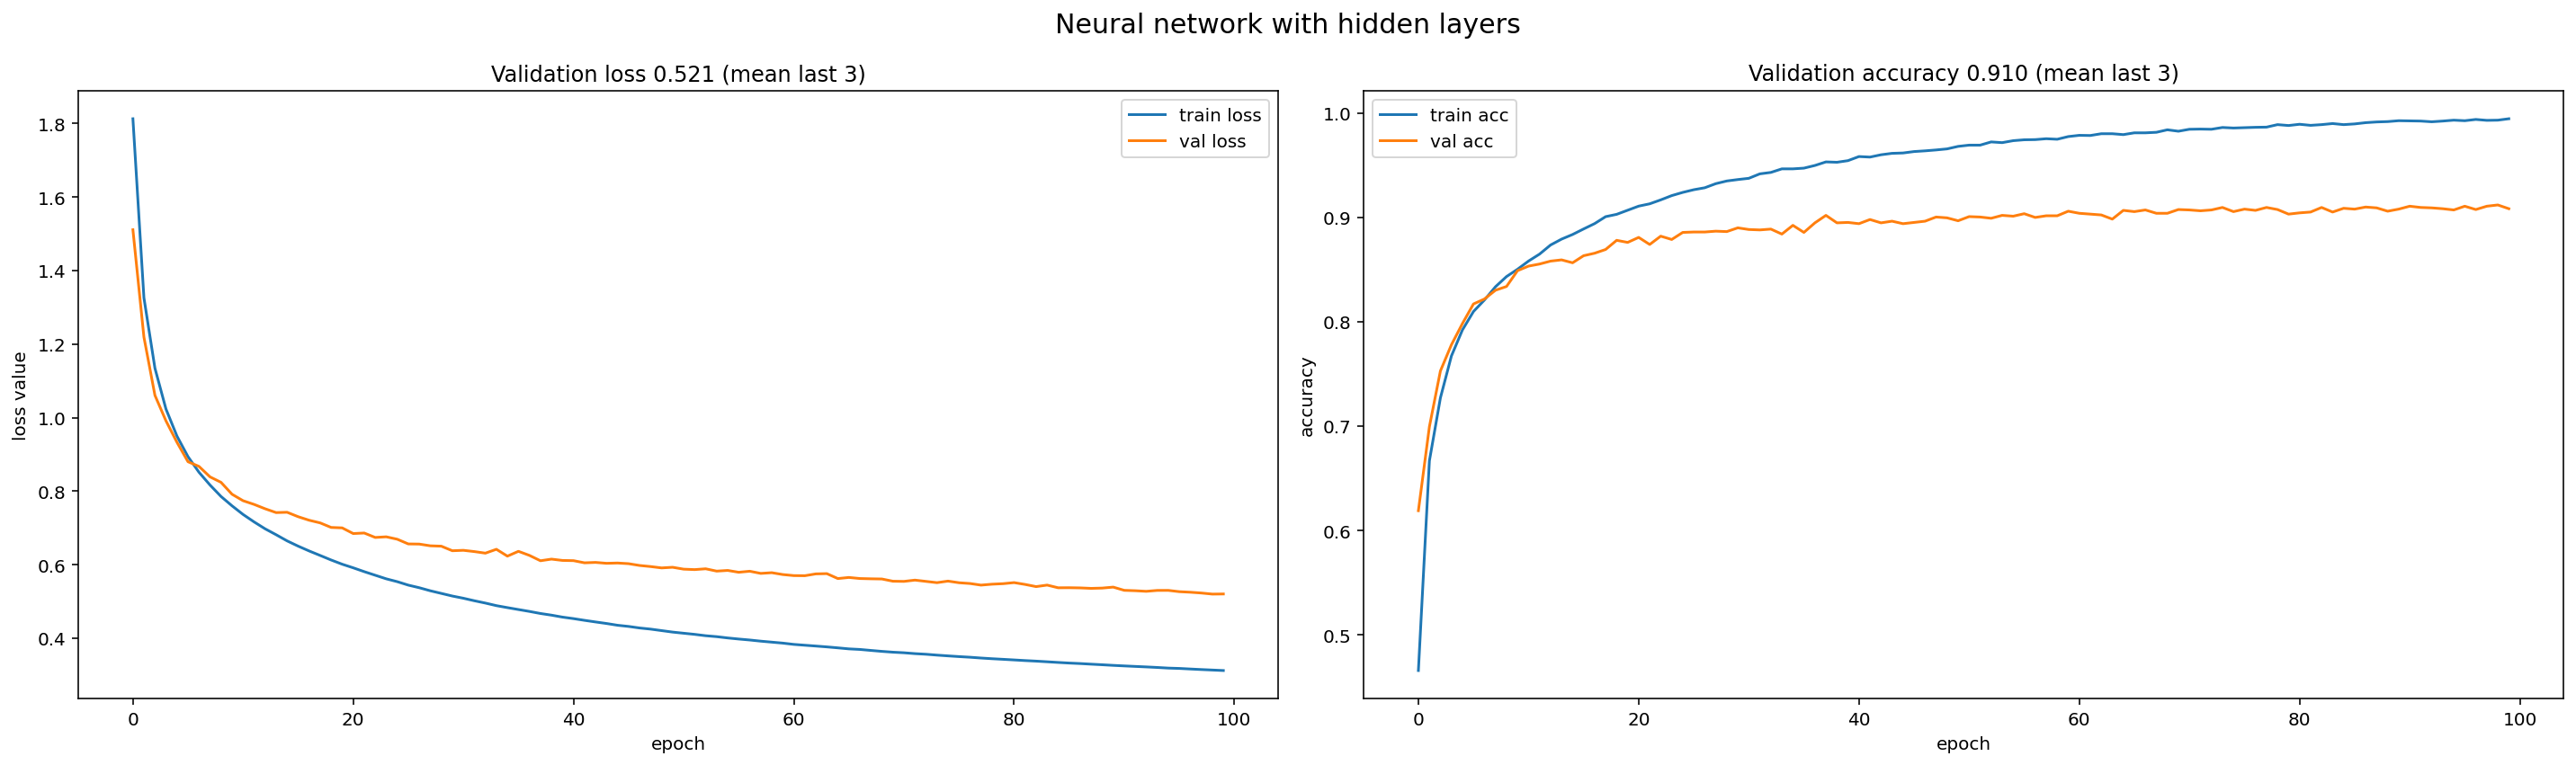

In [11]:
# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

plt.suptitle('Neural network with hidden layers', size=15)

# Plot accuracy values
ax1.plot(history.history["loss"], label="train loss")
ax1.plot(history.history["val_loss"], label="val loss")
ax1.set_title(
    "Validation loss {:.3f} (mean last 3)".format(
        np.mean(history.history["val_loss"][-3:])  # last three values
    )
)
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss value")
ax1.legend()

# Plot accuracy values
ax2.plot(history.history["acc"], label="train acc")
ax2.plot(history.history["val_acc"], label="val acc")
ax2.set_title(
    "Validation accuracy {:.3f} (mean last 3)".format(
        np.mean(history.history["val_acc"][-3:])  # last three values
    )
)
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.legend()
plt.tight_layout()
plt.show()

The training/validation curves have similar shapes to those of the previous model, although their values appear better. There also seems to be an increasing gap between the sets, with the training accuracy reaching almost the maximum value.

Like before, let's now evaluate the test scores:

In [12]:
(test_loss, test_accuracy) = model_hl.evaluate(X_te_rescaled, y_te, batch_size=32)

print("Test loss: {:.2f}".format(test_loss))
print("Test accuracy: {:.2f}%".format(100 * test_accuracy))

30/30 [==============================] - 0s 931us/step - loss: 0.4634 - acc: 0.9226
Test loss: 0.46
Test accuracy: 92.26%


That's an improvement of about 10%, only by adding few layers. Let's see the accuracies for each emotion using a confusion matrix again:

30/30 [==============================] - 0s 777us/step


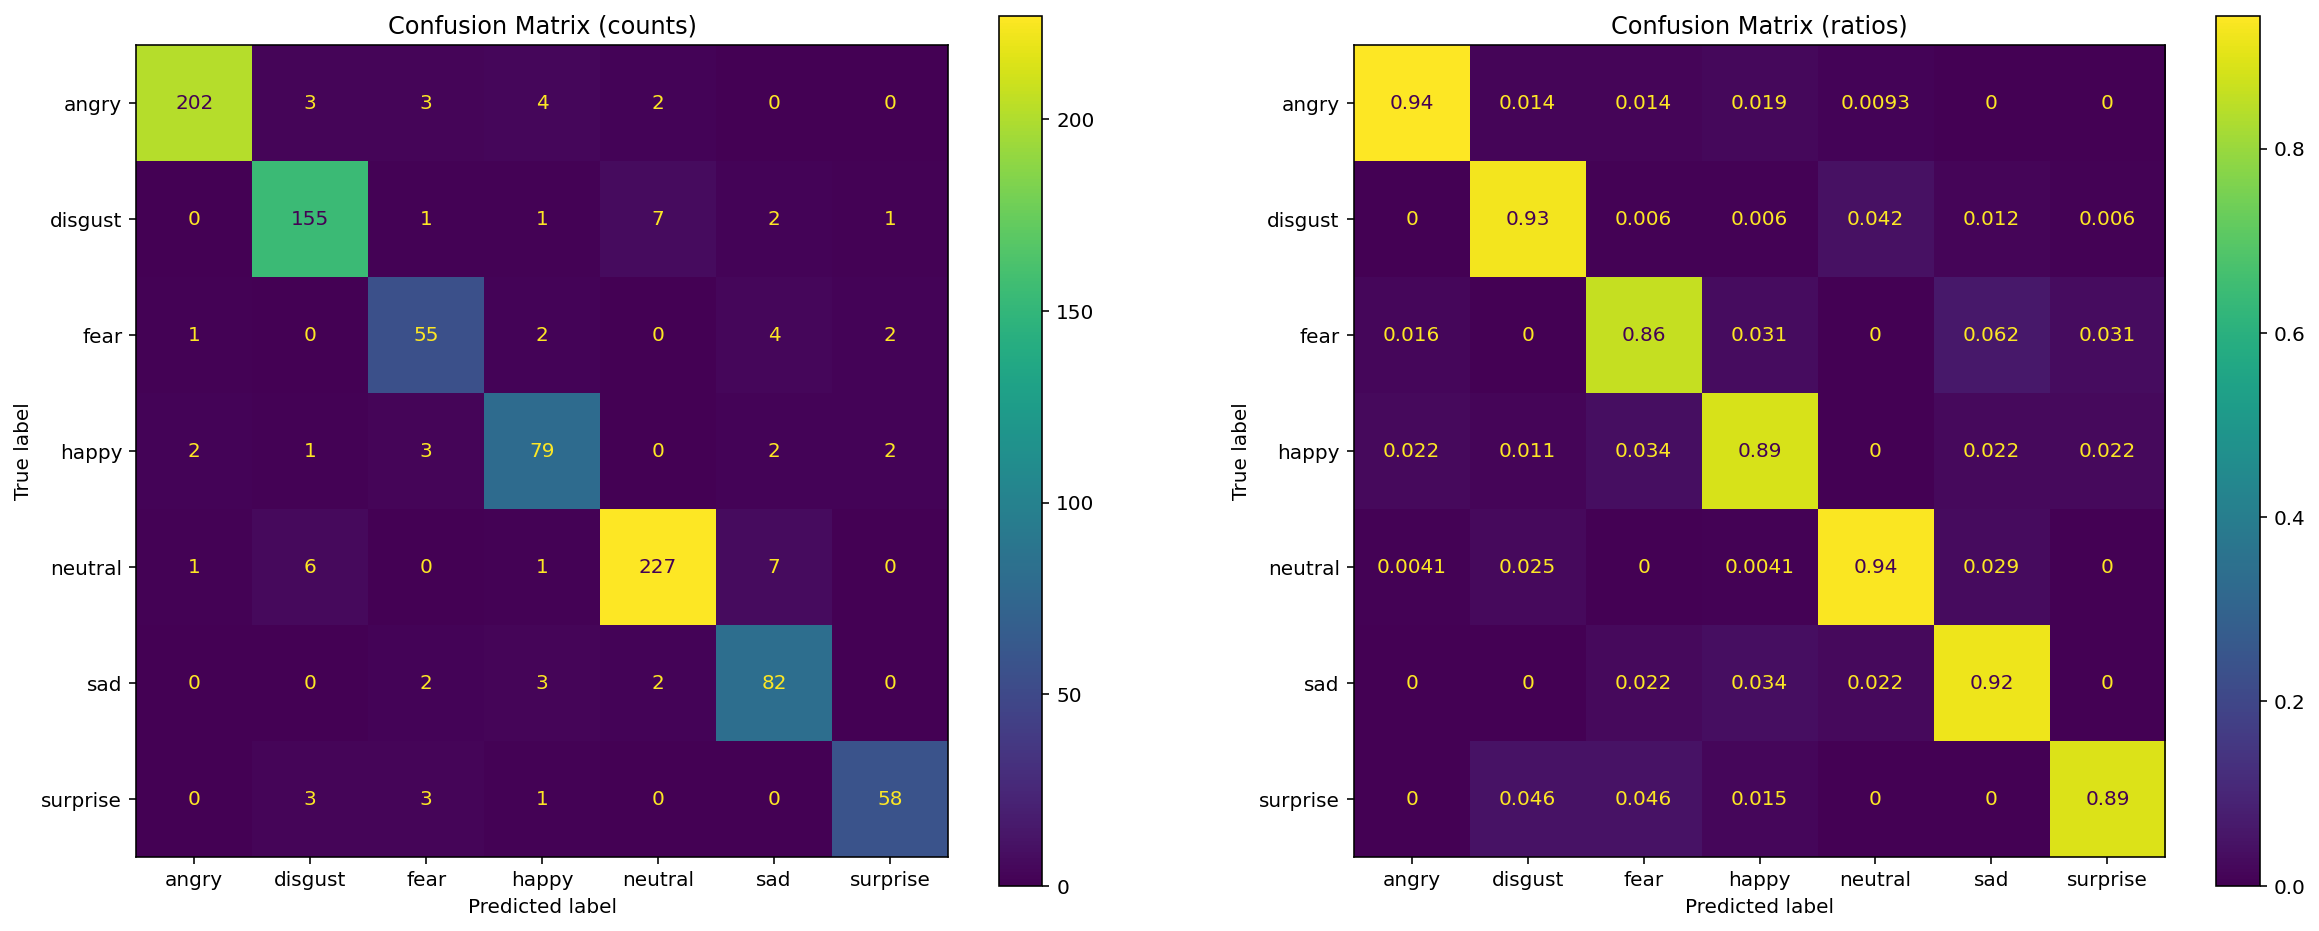

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

# Compute test set predictions
predictions = model_hl.predict(X_te_rescaled)

pred = []

for i in predictions:
    pred.append(np.argmax(i))
    
labels = {'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}

def plot_confusion_matrices(y_true, y_pred):

    # Create two subplots
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plots the standard confusion matrix
    ax1.set_title("Confusion Matrix (counts)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, ax=ax1)

    # Plots the normalized confusion matrix
    ax2.set_title("Confusion Matrix (ratios)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, normalize="true", ax=ax2)

    plt.show()

# Plot confusion matrices
plot_confusion_matrices(y_te, pred)

- The best predictions occurred for the `angry` and `disgust` emotions
- The worst for the `fear` and `happy` categories

<br>[Back to top](#top7)